# Pipeline Brain MRI Alzheimer — Notebook Didático

Fluxo linear em português (segmentação → descritores → dataset → modelos → visualizações) sem GUI/Tkinter.
Por padrão `DEMO_MODE=False`, recriando artefatos quando as células rodam; ajuste os *flags* abaixo se quiser comportamento mais leve.

In [1]:
# Visualizações dinâmicas (scatter + heatmap) sem depender de PNGs prontos
import seaborn as sns
sns.set_theme(style='whitegrid')

def _prefix_except(df, on, prefix):
    df = df.copy()
    cols_to_prefix = [c for c in df.columns if c != on]
    df.rename(columns={c: f'{prefix}{c}' for c in cols_to_prefix}, inplace=True)
    return df

def _merge_with_prefix(descriptor_df, exam_df, on=None, desc_prefix='desc_', exam_prefix='exam_'):
    if on:
        d = _prefix_except(descriptor_df, on, desc_prefix)
        e = _prefix_except(exam_df, on, exam_prefix)
        merged = pd.merge(d, e, on=on, how='inner')
    else:
        merged = descriptor_df.add_prefix(desc_prefix).join(exam_df.add_prefix(exam_prefix), how='inner')
    return merged

def _top_cross_correlations(df, left_cols, right_cols, top_n=5):
    corrs = []
    for l in left_cols:
        for r in right_cols:
            if pd.api.types.is_numeric_dtype(df[l]) and pd.api.types.is_numeric_dtype(df[r]):
                sub = df[[l, r]].dropna()
                if len(sub) < 3:
                    continue
                val = sub.corr().iloc[0, 1]
                corrs.append((abs(val), val, l, r))
    corrs.sort(reverse=True, key=lambda x: x[0])
    return corrs[:top_n]

def plot_scatter_and_heatmap(descriptor_df, exam_df, on='MRI_ID', max_pairs=4, save_png=False, outdir='output', heatmap_cols=None, figsize=(4,3)):
    merged = _merge_with_prefix(descriptor_df, exam_df, on=on)
    desc_cols = [c for c in merged.columns if c.startswith('desc_')]
    exam_cols = [c for c in merged.columns if c.startswith('exam_')]
    pairs = _top_cross_correlations(merged, desc_cols, exam_cols, top_n=max_pairs)
    if save_png:
        Path(outdir).mkdir(parents=True, exist_ok=True)
    for i, (_, corr_val, xcol, ycol) in enumerate(pairs, 1):
        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(data=merged, x=xcol, y=ycol, scatter_kws={'s':20, 'alpha':0.7}, line_kws={'color':'red'}, ax=ax)
        ax.set_title(f'{ycol} vs {xcol} (r={corr_val:.2f})')
        plt.tight_layout()
        if save_png:
            fig.savefig(Path(outdir)/f'scatter_{i}_{xcol}_vs_{ycol}.png', dpi=150, bbox_inches='tight')
        plt.show()
    heat_cols = heatmap_cols or merged.select_dtypes('number').columns
    if len(heat_cols) > 1:
        corr = merged[heat_cols].corr()
        fig, ax = plt.subplots(figsize=(max(6, 0.4*len(heat_cols)), max(4, 0.4*len(heat_cols))))
        sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink':0.75}, ax=ax)
        ax.set_title('Correlation Heatmap')
        plt.tight_layout()
        if save_png:
            fig.savefig(Path(outdir)/'correlation_heatmap.png', dpi=150, bbox_inches='tight')
        plt.show()

if 'exam_df' in globals() and 'desc_df' in globals() and not exam_df.empty and not desc_df.empty:
    plot_scatter_and_heatmap(desc_df, exam_df, on='MRI_ID', max_pairs=4, save_png=not DEMO_MODE)
else:
    print('Visualizações dinâmicas puladas: dados ausentes.')


Visualizações dinâmicas puladas: dados ausentes.


In [2]:
# Parameters
DEMO_MODE = False
RUN_SVM = True
RUN_XGB = True
RUN_DENSENET = False
RUN_DENSENET_TRAIN = False  # Treino leve opcional (CPU)
RUN_DENSENET_FULL = False   # Treino completo opcional (pode ser pesado em CPU)


In [3]:
from pathlib import Path

BASE_DIR = Path.cwd()
AXL_DIR = BASE_DIR / 'axl'
OUT_DIR = BASE_DIR / 'output'
DEMOGRAPHICS = BASE_DIR / 'oasis_longitudinal_demographic.csv'

DEMO_MODE = False       # Usa modo completo por padrão (recria/atualiza artefatos)
RUN_SEG_DEMO = False    # Segmentação de exemplo (2D)
RUN_DATASET = False     # Recriar exam_level_dataset_split.csv
RUN_SVM = False         # Re-treinar SVM
RUN_XGB = False         # Re-treinar XGBoost
RUN_DENSENET = False    # Treinar DenseNet (pesado)
RUN_DENSENET_TRAIN = False  # Treino leve opcional (CPU)
RUN_DENSENET_FULL = False   # Treino completo opcional (pode ser pesado em CPU)
RUN_TSNE = False        # Recalcular t-SNE/UMAP

print('BASE_DIR:', BASE_DIR)
print('AXL files:', len(list(AXL_DIR.glob('*.nii*'))))
print('OUT_DIR exists:', OUT_DIR.exists())
print('DEMOGRAPHICS exists:', DEMOGRAPHICS.exists())

BASE_DIR: /Volumes/ExternalSSD/GitHub/brain-mri-pipelines-py
AXL files: 368
OUT_DIR exists: True
DEMOGRAPHICS exists: True


In [4]:
import importlib, warnings, pickle, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_import(name, alias=None):
    try:
        m = importlib.import_module(name)
        if alias:
            globals()[alias] = m
        return m
    except Exception:
        warnings.warn(f'Pacote opcional ausente ou falha ao carregar: {name}')
        return None

nib = safe_import('nibabel')
sns = safe_import('seaborn', alias='sns')
xgboost = safe_import('xgboost')
torch = safe_import('torch')
torchvision = safe_import('torchvision')
sklearn = safe_import('sklearn')
skimage_filters = safe_import('skimage.filters')
skimage_morph = safe_import('skimage.morphology')
skimage_measure = safe_import('skimage.measure')
skimage_exposure = safe_import('skimage.exposure')
scipy_ndimage = safe_import('scipy.ndimage', alias='scipy_ndimage')

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = True


/var/folders/vr/kh908gkn06jgh4yy6pxh59ym0000gn/T/ipykernel_88364/2354942154.py:13: UserWarning: Pacote opcional ausente ou falha ao carregar: torch
  warnings.warn(f'Pacote opcional ausente ou falha ao carregar: {name}')
/var/folders/vr/kh908gkn06jgh4yy6pxh59ym0000gn/T/ipykernel_88364/2354942154.py:13: UserWarning: Pacote opcional ausente ou falha ao carregar: torchvision
  warnings.warn(f'Pacote opcional ausente ou falha ao carregar: {name}')
/var/folders/vr/kh908gkn06jgh4yy6pxh59ym0000gn/T/ipykernel_88364/2354942154.py:13: UserWarning: Pacote opcional ausente ou falha ao carregar: skimage.filters
  warnings.warn(f'Pacote opcional ausente ou falha ao carregar: {name}')
/var/folders/vr/kh908gkn06jgh4yy6pxh59ym0000gn/T/ipykernel_88364/2354942154.py:13: UserWarning: Pacote opcional ausente ou falha ao carregar: skimage.morphology
  warnings.warn(f'Pacote opcional ausente ou falha ao carregar: {name}')
/var/folders/vr/kh908gkn06jgh4yy6pxh59ym0000gn/T/ipykernel_88364/2354942154.py:13: User

In [5]:
# Utilidades de imagem/descritores (adaptadas do projeto)
def normalize_array(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32)
    mn, mx = img.min(), img.max()
    return (img - mn) / (mx - mn) if mx > mn else np.zeros_like(img)

def load_nifti_slice(path: Path, z_frac: float = 0.5):
    if nib is None: raise ImportError('nibabel não instalado')
    vol = np.asarray(nib.load(str(path)).get_fdata())
    vol = np.squeeze(vol)
    z = int(vol.shape[2] * z_frac) if vol.ndim == 3 else 0
    sl = vol if vol.ndim == 2 else vol[:, :, z]
    return normalize_array(sl)

def grow_region(image: np.ndarray, roi_size=(56,49), growth_steps: int = 3):
    if skimage_filters is None or skimage_morph is None or skimage_measure is None:
        raise ImportError('scikit-image não instalado')
    img_u8 = (image * 255).astype(np.uint8) if image.max() <= 1 else image.astype(np.uint8)
    h, w = img_u8.shape
    roi_h, roi_w = roi_size
    cy, cx = h//2, w//2
    roi_mask = np.zeros((h, w), dtype=bool)
    roi_mask[cy-roi_h//2:cy+roi_h//2, cx-roi_w//2:cx+roi_w//2] = True
    thresh = skimage_filters.threshold_otsu(img_u8)
    binary = skimage_morph.binary_opening(img_u8 < thresh, skimage_morph.disk(1))
    selem = skimage_morph.disk(2)
    grad = skimage_morph.dilation(img_u8, selem).astype(np.int16) - skimage_morph.erosion(img_u8, selem).astype(np.int16)
    labeled = skimage_measure.label(binary)
    seed = np.zeros_like(binary, dtype=bool)
    for region in skimage_measure.regionprops(labeled, intensity_image=img_u8):
        if np.any((labeled == region.label) & roi_mask):
            seed |= (labeled == region.label)
    grown = seed.copy()
    for _ in range(growth_steps):
        dilated = skimage_morph.binary_dilation(grown, skimage_morph.disk(1))
        boundary = dilated & ~grown
        valid = boundary & (img_u8 < thresh * 1.1) & (grad < np.percentile(grad, 80))
        grown |= valid
    refined = grown & (img_u8 < thresh * 1.15)
    refined = scipy_ndimage.binary_fill_holes(refined) if scipy_ndimage else refined
    refined = (scipy_ndimage.gaussian_filter(refined.astype(np.float32), sigma=1.5) > 0.5) if scipy_ndimage else refined
    refined = scipy_ndimage.binary_fill_holes(refined) if scipy_ndimage else refined
    return refined.astype(np.uint8), {'thresh': float(thresh), 'roi_mask': roi_mask}

def calculate_descriptors(mask: np.ndarray):
    if skimage_measure is None: raise ImportError('scikit-image não instalado')
    if not np.any(mask):
        return {k:0.0 for k in ['area','perimeter','circularity','eccentricity','solidity','major_axis_length','minor_axis_length']}
    labeled = skimage_measure.label(mask > 0)
    regions = skimage_measure.regionprops(labeled)
    area = sum(r.area for r in regions)
    perimeter = sum(r.perimeter for r in regions)
    circ = (4*np.pi*area)/(perimeter**2) if perimeter>0 else 0
    def wavg(attr):
        num = sum(getattr(r, attr)*r.area for r in regions); den = sum(r.area for r in regions); return num/den if den else 0
    return {
        'area': float(area), 'perimeter': float(perimeter), 'circularity': float(circ),
        'eccentricity': float(wavg('eccentricity')), 'solidity': float(wavg('solidity')),
        'major_axis_length': float(wavg('major_axis_length')), 'minor_axis_length': float(wavg('minor_axis_length')),
    }

def compute_longitudinal(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty: return df
    df = df.copy()
    if 'visit_number' not in df.columns:
        df['visit_number'] = df['MRI_ID'].str.extract(r'MR(\d+)').astype(float)
    change_map = {
        'ventricle_area': 'area_change',
        'ventricle_perimeter': 'perimeter_change',
        'ventricle_circularity': 'circularity_change',
        'ventricle_eccentricity': 'eccentricity_change',
        'ventricle_solidity': 'solidity_change',
        'ventricle_major_axis_length': 'major_axis_change',
        'ventricle_minor_axis_length': 'minor_axis_change',
    }
    for col in list(change_map.values()) + ['area_change_percent']:
        if col not in df.columns: df[col] = np.nan
    for sid, sub in df.groupby('Subject_ID'):
        sub = sub.sort_values('visit_number')
        prev = None
        for idx, row in sub.iterrows():
            if prev is None:
                prev = row; continue
            for src, dst in change_map.items():
                if src in df.columns and pd.notna(prev[src]) and pd.notna(row[src]):
                    df.loc[idx, dst] = row[src] - prev[src]
            if pd.notna(prev.get('ventricle_area', np.nan)) and prev.get('ventricle_area', np.nan) != 0 and pd.notna(row.get('ventricle_area', np.nan)):
                df.loc[idx, 'area_change_percent'] = ((row['ventricle_area'] - prev['ventricle_area'])/prev['ventricle_area'])*100
            prev = row
    return df

def update_descriptors_csv(csv_path: Path, mri_id: str, descriptors: dict, seg_path: str, demo: bool = DEMO_MODE):
    if demo and csv_path.exists():
        return pd.read_csv(csv_path)
    df = pd.read_csv(csv_path) if csv_path.exists() else pd.DataFrame()
    record = {
        'MRI_ID': mri_id.replace('_axl',''),
        'Subject_ID': mri_id.split('_MR')[0],
        'viable': True,
        'segmented_path': seg_path,
        'ventricle_area': descriptors.get('area'),
        'ventricle_perimeter': descriptors.get('perimeter'),
        'ventricle_circularity': descriptors.get('circularity'),
        'ventricle_eccentricity': descriptors.get('eccentricity'),
        'ventricle_solidity': descriptors.get('solidity'),
        'ventricle_major_axis_length': descriptors.get('major_axis_length'),
        'ventricle_minor_axis_length': descriptors.get('minor_axis_length'),
    }
    if df.empty: df = pd.DataFrame(columns=record.keys())
    df = pd.concat([df, pd.DataFrame([record])], ignore_index=True)
    df = compute_longitudinal(df)
    if not demo:
        csv_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(csv_path, index=False)
    return df

def show_png(path: Path, title: str = ''):
    try:
        import PIL.Image as Image
    except ImportError:
        print('Pillow ausente; não é possível exibir', path); return
    if not path.exists():
        print('Arquivo não encontrado:', path); return
    img = Image.open(path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title or path.name)
    plt.show()

def read_csv_safe(path: Path, **kwargs):
    if not path.exists():
        print('Arquivo CSV ausente:', path)
        return pd.DataFrame()
    return pd.read_csv(path, **kwargs)


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0,1987,"0,696","0,883"
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0,2004,"0,681","0,876"
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,"0,5",1678,"0,736","1,046"
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,"0,5",1738,"0,713","1,010"
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,"0,5",1698,"0,701","1,034"


Entradas demográficas: 373


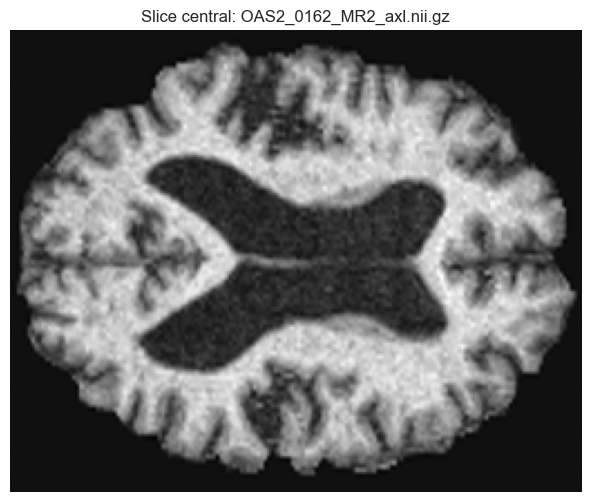

In [6]:
# Inspeção rápida dos dados
if DEMOGRAPHICS.exists():
    demo_df = pd.read_csv(DEMOGRAPHICS, sep=';')
    display(demo_df.head())
    print('Entradas demográficas:', len(demo_df))
else:
    print('Arquivo demográfico não encontrado.')

sample_nii = next(iter(AXL_DIR.glob('*.nii*')), None)
if sample_nii and nib is not None:
    sl = load_nifti_slice(sample_nii)
    plt.imshow(sl, cmap='gray'); plt.axis('off'); plt.title(f'Slice central: {sample_nii.name}'); plt.show()
else:
    print('Nenhum NIfTI encontrado ou nibabel indisponível.')


In [7]:
# Segmentação demonstrativa opcional
if RUN_SEG_DEMO and sample_nii and nib is not None and skimage_filters is not None:
    sl = load_nifti_slice(sample_nii)
    mask, meta = grow_region(sl)
    desc = calculate_descriptors(mask)
    print('Descritores da fatia:', desc)
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(sl, cmap='gray'); ax[0].set_title('Fatia')
    ax[1].imshow(mask, cmap='gray'); ax[1].set_title(f'Máscara Otsu (th={meta["thresh"]:.1f})')
    ax[2].imshow(sl, cmap='gray'); ax[2].imshow(mask, alpha=0.4, cmap='autumn'); ax[2].set_title('Sobreposição')
    for a in ax: a.axis('off')
    plt.show()
else:
    print('Segmentação demo pulada (RUN_SEG_DEMO=False ou dependências ausentes).')


Segmentação demo pulada (RUN_SEG_DEMO=False ou dependências ausentes).


In [8]:
# Dataset combinado exam_level_dataset_split.csv
descriptors_path = OUT_DIR / 'ventricle_descriptors.csv'
dataset_split_path = OUT_DIR / 'exam_level_dataset_split.csv'

def build_exam_dataset(force: bool = False):
    if DEMO_MODE and dataset_split_path.exists() and not force:
        return pd.read_csv(dataset_split_path)
    df_desc = read_csv_safe(descriptors_path)
    if df_desc.empty:
        print('Descritores indisponíveis.'); return df_desc
    demo = pd.read_csv(DEMOGRAPHICS, sep=';') if DEMOGRAPHICS.exists() else pd.DataFrame()
    if demo.empty:
        print('Demografia ausente.'); return pd.DataFrame()
    demo = demo.rename(columns={'Subject ID':'Subject_ID','MRI ID':'MRI_ID','Group':'Group','Visit':'Visit','Age':'age','M/F':'M/F','MMSE':'mmse','CDR':'cdr'})
    for col in ['age','mmse','cdr']:
        if col in demo.columns:
            demo[col] = demo[col].astype(str).str.replace(',','.').astype(float)
    merged = pd.merge(df_desc, demo, how='left', on=['Subject_ID','MRI_ID'])
    merged['Final_Group'] = merged['Group'].map({'Nondemented':0,'Demented':1,'Converted':1})
    merged['split'] = 'train'
    if 'Subject_ID' in merged.columns and not merged['Subject_ID'].dropna().empty:
        from sklearn.model_selection import train_test_split
        subs = merged[['Subject_ID','Final_Group']].dropna().drop_duplicates('Subject_ID')
        subj_labels = subs.groupby('Subject_ID')['Final_Group'].agg(lambda s: s.mode().iloc[0] if len(s)>0 else 0)
        subj_ids = subj_labels.index.values
        y_subj = subj_labels.values
        test_size = 0.2 if len(subj_ids) > 4 else 0.0
        val_size = 0.2 if len(subj_ids) > 3 else 0.0
        if test_size > 0:
            subj_train, subj_temp, y_train_s, y_temp_s = train_test_split(subj_ids, y_subj, test_size=test_size, stratify=y_subj, random_state=42)
        else:
            subj_train, subj_temp, y_train_s, y_temp_s = subj_ids, [], y_subj, []
        if val_size > 0 and len(subj_temp) > 1:
            subj_val, subj_test, y_val_s, y_test_s = train_test_split(subj_temp, y_temp_s, test_size=0.5, stratify=y_temp_s if len(set(y_temp_s))>1 else None, random_state=42)
        else:
            subj_val, subj_test = subj_temp, []
        merged.loc[merged['Subject_ID'].isin(subj_val), 'split'] = 'val'
        merged.loc[merged['Subject_ID'].isin(subj_test), 'split'] = 'test'
    merged = compute_longitudinal(merged)
    if not DEMO_MODE or force:
        merged.to_csv(dataset_split_path, index=False)
    return merged

exam_df = build_exam_dataset(force=RUN_DATASET)
if not exam_df.empty:
    display(exam_df.head())
    if 'split' in exam_df.columns:
        print(exam_df['split'].value_counts())
else:
    print('Dataset unificado indisponível.')


,MRI_ID,Subject_ID,viable,segmented_path,ventricle_area,ventricle_perimeter,ventricle_circularity,ventricle_eccentricity,ventricle_solidity,ventricle_major_axis_length,...,age,EDUC,SES,mmse,cdr,eTIV,nWBV,ASF,Final_Group,split
0,OAS2_0001_MR1,OAS2_0001,True,output/OAS2_0001_MR1_axl_segmented.png,5121.0,593.168614,0.182898,0.778095,0.507482,141.141640,...,87.0,14,2.0,27.0,0.0,1987,"0,696","0,883",0,train
1,OAS2_0001_MR2,OAS2_0001,True,output/OAS2_0001_MR2_axl_segmented.png,5468.0,594.097546,0.194681,0.777340,0.527341,142.454108,...,88.0,14,2.0,30.0,0.0,2004,"0,681","0,876",0,train
2,OAS2_0002_MR1,OAS2_0002,True,output/OAS2_0002_MR1_axl_segmented.png,4560.0,448.315801,0.285106,0.816526,0.559647,127.825378,...,75.0,12,NaN,23.0,0.5,1678,"0,736","1,046",1,test
3,OAS2_0002_MR2,OAS2_0002,True,output/OAS2_0002_MR2_axl_segmented.png,4896.0,455.629509,0.296365,0.803819,0.581128,127.981684,...,76.0,12,NaN,28.0,0.5,1738,"0,713","1,010",1,test
4,OAS2_0002_MR3,OAS2_0002,True,output/OAS2_0002_MR3_axl_segmented.png,5604.0,462.558441,0.329136,0.796449,0.621424,131.290036,...,80.0,12,NaN,22.0,0.5,1698,"0,701","1,034",1,test


split
train    292
test      38
val       38
Name: count, dtype: int64


In [9]:
RUN_DENSENET_TRAIN = False  # Treino leve opcional (CPU)
RUN_DENSENET_FULL = False   # Treino completo opcional (pode ser pesado em CPU)
# SVM (carrega modelo pronto no modo demo)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def run_svm(df: pd.DataFrame):
    model_path = OUT_DIR / 'svm_model.pkl'
    scaler_path = OUT_DIR / 'svm_scaler.pkl'
    feat_cols = ['ventricle_area','ventricle_perimeter','ventricle_circularity','ventricle_eccentricity','ventricle_solidity','ventricle_major_axis_length','ventricle_minor_axis_length']
    df = df.dropna(subset=feat_cols + ['Final_Group'])
    if df.empty:
        print('Sem dados para SVM.'); return
    X = df[feat_cols].astype(float); y = df['Final_Group'].astype(int)
    # Usa split por sujeito se disponível
    if 'split' in df.columns and df['split'].nunique() > 1:
        train_mask = df['split'].eq('train')
        test_mask = ~train_mask
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    if DEMO_MODE and model_path.exists() and scaler_path.exists():
        with open(model_path,'rb') as f: model = pickle.load(f)
        with open(scaler_path,'rb') as f: scaler = pickle.load(f)
    else:
        scaler = StandardScaler().fit(X_train)
        model = SVC(kernel='rbf', C=4, gamma='scale', probability=True, random_state=42)
        model.fit(scaler.transform(X_train), y_train)
        if not DEMO_MODE:
            with open(model_path,'wb') as f: pickle.dump(model,f)
            with open(scaler_path,'wb') as f: pickle.dump(scaler,f)
    y_pred = model.predict(scaler.transform(X_test))
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('SVM (avaliação)'); plt.show();

if not exam_df.empty and RUN_SVM:
    run_svm(exam_df)
else:
    print('SVM executado apenas em modo leitura (DEMO usa métricas pré-computadas em PNG).')


SVM executado apenas em modo leitura (DEMO usa métricas pré-computadas em PNG).


In [10]:
# XGBoost regressão de idade
if xgboost is not None:
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    def run_xgb(df: pd.DataFrame):
        model_path = OUT_DIR / 'xgb_age.pkl'
        feat_cols = ['ventricle_area','ventricle_perimeter','ventricle_circularity','ventricle_eccentricity','ventricle_solidity','ventricle_major_axis_length','ventricle_minor_axis_length']
        df_age = df.dropna(subset=feat_cols + ['age'])
        if df_age.empty:
            print('Sem dados para regressão.'); return
        X = df_age[feat_cols].astype(float); y = df_age['age'].astype(float)
        if 'split' in df_age.columns and df_age['split'].nunique() > 1:
            train_mask = df_age['split'].eq('train')
            test_mask = ~train_mask
            X_train, y_train = X[train_mask], y[train_mask]
            X_test, y_test = X[test_mask], y[test_mask]
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        if DEMO_MODE and model_path.exists():
            with open(model_path,'rb') as f: model = pickle.load(f)
        else:
            model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=150, random_state=42, max_depth=4, learning_rate=0.05, subsample=0.8)
            model.fit(X_train, y_train)
            if not DEMO_MODE:
                with open(model_path,'wb') as f: pickle.dump(model,f)
        y_pred = model.predict(X_test if 'X_test' in locals() else X)
        y_true = y_test if 'y_test' in locals() else y
        print('MAE:', mean_absolute_error(y_true, y_pred), 'RMSE:', mean_squared_error(y_true, y_pred, squared=False))
        plt.scatter(y_true, y_pred, alpha=0.5);
        minv,maxv = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max());
        plt.plot([minv,maxv],[minv,maxv],'r--'); plt.xlabel('Idade real'); plt.ylabel('Predito'); plt.show();
    if not exam_df.empty and RUN_XGB:
        run_xgb(exam_df)
    else:
        print('XGBoost não executado (DEMO usa PNGs prontos).')
else:
    print('xgboost não instalado; seção pulada.')


XGBoost não executado (DEMO usa PNGs prontos).


In [ ]:

# DenseNet treino leve opcional (CPU-friendly)
if torch is not None and torchvision is not None:
    from brain_mri.ml.training_utils import build_densenet, build_transforms
    from brain_mri.ml.datasets import MRIDataset
    from torch.utils.data import DataLoader
    def run_densenet_train(df, checkpoint_path, mode='classification', epochs=1, max_samples=16):
        if df.empty:
            print('DenseNet treino pulado: dataset vazio.'); return
        tf_train = build_transforms(mode)
        tf_val = build_transforms(mode)
        df_train = df[df.get('split')=='train'].head(max_samples)
        df_val = df[df.get('split')=='val'].head(max_samples//2)
        if df_train.empty or df_val.empty:
            print('DenseNet treino pulado: splits insuficientes.'); return
        ds_train = MRIDataset(df_train, tf_train, AXL_DIR.parent, 'segmented_path', 'Final_Group' if mode=='classification' else 'age')
        ds_val = MRIDataset(df_val, tf_val, AXL_DIR.parent, 'segmented_path', 'Final_Group' if mode=='classification' else 'age')
        loader_train = DataLoader(ds_train, batch_size=4, shuffle=True)
        loader_val = DataLoader(ds_val, batch_size=4, shuffle=False)
        model = build_densenet(mode=mode)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = torch.nn.CrossEntropyLoss() if mode=='classification' else torch.nn.MSELoss()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        for epoch in range(epochs):
            model.train(); total=0
            for xb, yb in loader_train:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                out = model(xb)
                if mode=='classification':
                    loss = loss_fn(out, yb.long())
                else:
                    loss = loss_fn(out.view(-1), yb.float())
                loss.backward(); opt.step(); total += loss.item()
            print(f'Epoch {epoch+1}: train_loss={total/len(loader_train):.4f}')
        model.eval();
        with torch.no_grad():
            y_true=[]; y_pred=[]
            for xb, yb in loader_val:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                if mode=='classification':
                    pred = out.softmax(1).argmax(1)
                else:
                    pred = out.view(-1)
                y_true.append(yb.cpu()); y_pred.append(pred.cpu())
            import torch
            y_true = torch.cat(y_true)
            y_pred = torch.cat(y_pred)
            if mode=='classification':
                from sklearn.metrics import confusion_matrix
                cm = confusion_matrix(y_true, y_pred)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('DenseNet treino (mini) - CM'); plt.show()
            else:
                import numpy as np
                y_t = y_true.numpy(); y_p = y_pred.numpy()
                plt.scatter(y_t, y_p, alpha=0.6);
                mn,mx = min(y_t.min(), y_p.min()), max(y_t.max(), y_p.max())
                plt.plot([mn,mx],[mn,mx],'r--'); plt.title('DenseNet treino (mini) - regressão'); plt.xlabel('Real'); plt.ylabel('Pred'); plt.show()
        torch.save(model.state_dict(), checkpoint_path)
        print('Checkpoint salvo em', checkpoint_path)
    if RUN_DENSENET_TRAIN:
        cls_ckpt = OUT_DIR / 'densenet_classification_mini.pth'
        reg_ckpt = OUT_DIR / 'densenet_regression_mini.pth'
        if not exam_df.empty:
            run_densenet_train(exam_df, cls_ckpt, mode='classification', epochs=1, max_samples=16)
            if 'age' in exam_df.columns:
                run_densenet_train(exam_df, reg_ckpt, mode='regression', epochs=1, max_samples=16)
        else:
            print('DenseNet treino pulado: exam_df vazio.')
    else:
        print('DenseNet treino leve desativado (RUN_DENSENET_TRAIN=False).')
else:
    print('PyTorch/torchvision ausentes; treino DenseNet pulado.')


In [ ]:
# DenseNet treino leve opcional (CPU-friendly)
if torch is not None and torchvision is not None:
    from brain_mri.ml.training_utils import build_densenet, build_transforms
    from brain_mri.ml.datasets import MRIDataset
    from torch.utils.data import DataLoader
    import numpy as np
    def run_densenet_train(df, checkpoint_path, mode='classification', epochs=1, max_samples=16):
        if df.empty:
            print('DenseNet treino pulado: dataset vazio.'); return
        tf_train = build_transforms(mode)
        tf_val = build_transforms(mode)
        df_train = df[df.get('split')=='train'].head(max_samples)
        df_val = df[df.get('split')=='val'].head(max_samples//2)
        if df_train.empty or df_val.empty:
            print('DenseNet treino pulado: splits insuficientes.'); return
        ds_train = MRIDataset(df_train, tf_train, AXL_DIR.parent, 'segmented_path', 'Final_Group' if mode=='classification' else 'age')
        ds_val = MRIDataset(df_val, tf_val, AXL_DIR.parent, 'segmented_path', 'Final_Group' if mode=='classification' else 'age')
        loader_train = DataLoader(ds_train, batch_size=4, shuffle=True)
        loader_val = DataLoader(ds_val, batch_size=4, shuffle=False)
        model = build_densenet(mode=mode)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = torch.nn.CrossEntropyLoss() if mode=='classification' else torch.nn.MSELoss()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        for epoch in range(epochs):
            model.train(); total=0
            for xb, yb in loader_train:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                out = model(xb)
                loss = loss_fn(out, yb.long()) if mode=='classification' else loss_fn(out.view(-1), yb.float())
                loss.backward(); opt.step(); total += loss.item()
            print('Epoch {} train_loss {:.4f}'.format(epoch+1, total/len(loader_train)))
        model.eval(); y_true=[]; y_pred=[]
        with torch.no_grad():
            for xb, yb in loader_val:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                pred = out.softmax(1).argmax(1) if mode=='classification' else out.view(-1)
                y_true.append(yb.cpu()); y_pred.append(pred.cpu())
        y_true = torch.cat(y_true); y_pred = torch.cat(y_pred)
        if mode=='classification':
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('DenseNet mini (CM)'); plt.show()
        else:
            yt, yp = y_true.numpy(), y_pred.numpy()
            plt.scatter(yt, yp, alpha=0.6); mn, mx = min(yt.min(), yp.min()), max(yt.max(), yp.max())
            plt.plot([mn,mx],[mn,mx],'r--'); plt.title('DenseNet mini (reg)'); plt.xlabel('Real'); plt.ylabel('Pred'); plt.show()
        torch.save(model.state_dict(), checkpoint_path)
        print('Checkpoint salvo em', checkpoint_path)
    if RUN_DENSENET_TRAIN:
        cls_ckpt = OUT_DIR / 'densenet_classification_mini.pth'
        reg_ckpt = OUT_DIR / 'densenet_regression_mini.pth'
        if not exam_df.empty:
            run_densenet_train(exam_df, cls_ckpt, mode='classification', epochs=1, max_samples=16)
            if 'age' in exam_df.columns:
                run_densenet_train(exam_df, reg_ckpt, mode='regression', epochs=1, max_samples=16)
        else:
            print('DenseNet treino pulado: exam_df vazio.')
    else:
        print('DenseNet treino leve desativado (RUN_DENSENET_TRAIN=False).')
else:
    print('PyTorch/torchvision ausentes; treino DenseNet pulado.')


In [ ]:
# DenseNet treino completo opcional (CPU seguro, poucas épocas)
if torch is not None and torchvision is not None:
    from brain_mri.ml.training_utils import build_densenet, build_transforms
    from brain_mri.ml.datasets import MRIDataset
    from torch.utils.data import DataLoader
    import numpy as np
    def run_densenet_full(df, checkpoint_path, mode='classification', epochs=2, batch_size=4):
        if df.empty:
            print('DenseNet full pulado: dataset vazio.'); return
        tf_train = build_transforms(mode)
        tf_val = build_transforms(mode)
        df_train = df[df.get('split').eq('train')]
        df_val = df[df.get('split').eq('val')]
        if df_train.empty or df_val.empty:
            print('DenseNet full pulado: splits insuficientes.'); return
        # optional cap to keep CPU manageable
        df_train = df_train.head(64)
        df_val = df_val.head(32)
        ds_train = MRIDataset(df_train, tf_train, AXL_DIR.parent, 'segmented_path', 'Final_Group' if mode=='classification' else 'age')
        ds_val = MRIDataset(df_val, tf_val, AXL_DIR.parent, 'segmented_path', 'Final_Group' if mode=='classification' else 'age')
        loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
        loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
        model = build_densenet(mode=mode)
        opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
        loss_fn = torch.nn.CrossEntropyLoss() if mode=='classification' else torch.nn.MSELoss()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        train_loss_hist=[]; val_loss_hist=[]
        for epoch in range(epochs):
            model.train(); total=0
            for xb, yb in loader_train:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad(); out=model(xb)
                loss = loss_fn(out, yb.long()) if mode=='classification' else loss_fn(out.view(-1), yb.float())
                loss.backward(); opt.step(); total += loss.item()
            train_loss = total/len(loader_train)
            # val
            model.eval(); vtot=0
            with torch.no_grad():
                for xb, yb in loader_val:
                    xb, yb = xb.to(device), yb.to(device)
                    out=model(xb)
                    loss = loss_fn(out, yb.long()) if mode=='classification' else loss_fn(out.view(-1), yb.float())
                    vtot += loss.item()
            val_loss = vtot/len(loader_val)
            train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)
            print(f'Epoch {epoch+1}: train_loss={train_loss:.4f} val_loss={val_loss:.4f}')
        # simple plot
        import matplotlib.pyplot as plt
        plt.plot(range(1,len(train_loss_hist)+1), train_loss_hist, label='train_loss')
        plt.plot(range(1,len(val_loss_hist)+1), val_loss_hist, label='val_loss')
        plt.legend(); plt.title('DenseNet mini-full (loss)'); plt.xlabel('época'); plt.show()
        torch.save(model.state_dict(), checkpoint_path)
        print('Checkpoint salvo em', checkpoint_path)
    if RUN_DENSENET_FULL:
        cls_ckpt = OUT_DIR / 'densenet_classification_full.pth'
        reg_ckpt = OUT_DIR / 'densenet_regression_full.pth'
        if not exam_df.empty:
            run_densenet_full(exam_df, cls_ckpt, mode='classification', epochs=2, batch_size=4)
            if 'age' in exam_df.columns:
                run_densenet_full(exam_df, reg_ckpt, mode='regression', epochs=2, batch_size=4)
        else:
            print('DenseNet full pulado: exam_df vazio.')
    else:
        print('DenseNet full desativado (RUN_DENSENET_FULL=False).')
else:
    print('PyTorch/torchvision ausentes; treino DenseNet pulado.')


In [11]:
# DenseNet: inferência leve a partir de checkpoints existentes (sem treino por padrão)
if torch is not None and torchvision is not None:
    try:
        from brain_mri.ml.training_utils import build_densenet, build_transforms
        from brain_mri.ml.datasets import MRIDataset
        from torch.utils.data import DataLoader
        import torch.nn.functional as F

        def densenet_infer(df, mode='classification', checkpoint=None, n_samples=8):
            if checkpoint is None or not checkpoint.exists():
                print('Checkpoint ausente:', checkpoint); return
            if df.empty:
                print('Dados vazios para inferência.'); return
            tf = build_transforms(mode)
            use_df = df.sample(min(len(df), n_samples), random_state=42)
            ds = MRIDataset(use_df, transform=tf, root_dir=AXL_DIR.parent, path_col='segmented_path', label_col='Final_Group' if mode=='classification' else 'age')
            loader = DataLoader(ds, batch_size=4, shuffle=False)
            model = build_densenet(mode=mode)
            state = torch.load(checkpoint, map_location='cpu')
            if isinstance(state, dict) and 'state_dict' in state: state = state['state_dict']
            model.load_state_dict(state, strict=False)
            model.eval()
            ys, preds = [], []
            with torch.no_grad():
                for x, y in loader:
                    out = model(x)
                    if mode == 'classification':
                        pred = out.softmax(1).argmax(1)
                    else:
                        pred = out.squeeze()
                    preds.append(pred.cpu())
                    ys.append(y)
            import numpy as np
            ys = torch.cat(ys).cpu().numpy()
            preds = torch.cat(preds).cpu().numpy()
            if mode == 'classification':
                from sklearn.metrics import confusion_matrix
                cm = confusion_matrix(ys, preds)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('DenseNet (ckpt)'); plt.show()
            else:
                plt.scatter(ys, preds, alpha=0.6)
                mn, mx = min(ys.min(), preds.min()), max(ys.max(), preds.max())
                plt.plot([mn, mx], [mn, mx], 'r--'); plt.xlabel('Idade real'); plt.ylabel('Predito'); plt.title('DenseNet regressão (ckpt)'); plt.show()

        if RUN_DENSENET:
            # Inferência em checkpoints existentes (sem treino novo)
            cls_ckpt = OUT_DIR / 'densenet_classification.pth'
            reg_ckpt = OUT_DIR / 'densenet_regression.pth'
            if not exam_df.empty:
                densenet_infer(exam_df[exam_df['split']!='train'], mode='classification', checkpoint=cls_ckpt, n_samples=8)
                if 'age' in exam_df.columns:
                    densenet_infer(exam_df[exam_df['split']!='train'], mode='regression', checkpoint=reg_ckpt, n_samples=8)
            else:
                print('Inferência DenseNet pulada: exam_df vazio.')
        else:
            print('DenseNet não executado (RUN_DENSENET=False).')
    except Exception as e:
        print('Falha na seção DenseNet:', e)
else:
    print('PyTorch/torchvision ausentes; seção DenseNet pulada.')


PyTorch/torchvision ausentes; seção DenseNet pulada.


In [12]:
# DenseNet: inferência leve (nenhum treino por padrão)
if torch is not None and torchvision is not None:
    try:
        from brain_mri.ml.training_utils import build_densenet
        def densenet_infer_single(checkpoint: Path, mode='classification'):
            if not checkpoint.exists():
                print('Checkpoint ausente:', checkpoint); return
            model = build_densenet(mode=mode)
            state = torch.load(checkpoint, map_location='cpu')
            if isinstance(state, dict) and 'state_dict' in state: state = state['state_dict']
            model.load_state_dict(state, strict=False)
            model.eval()
            x = torch.zeros(1,3,224,224)
            with torch.no_grad(): out = model(x)
            print('Saída dummy shape:', tuple(out.shape))
        if RUN_DENSENET:
            densenet_infer_single(OUT_DIR/'densenet_classification.pth', mode='classification')
        else:
            print('DenseNet não treinado aqui; apenas carregue checkpoints se desejar (RUN_DENSENET=True).')
    except Exception as e:
        print('Falha ao carregar DenseNet:', e)
else:
    print('PyTorch/torchvision ausentes; seção DenseNet pulada.')


PyTorch/torchvision ausentes; seção DenseNet pulada.


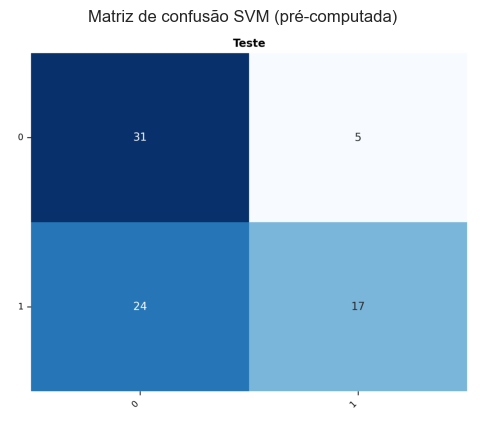

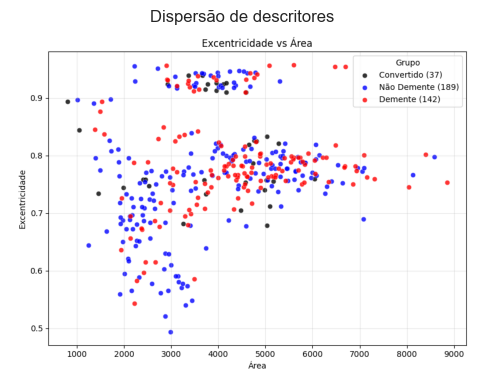

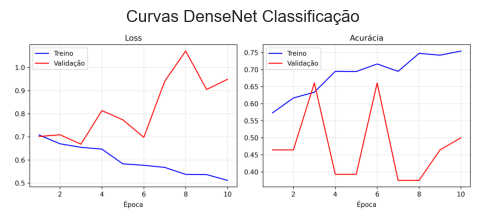

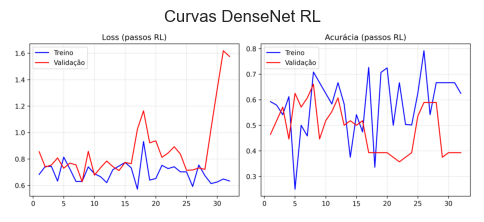

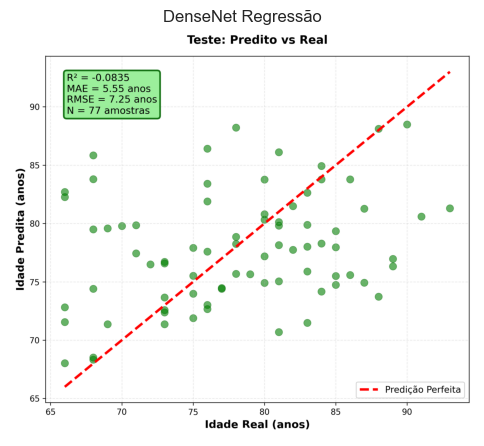

In [13]:
# Visualizações prontas (PNGs)
show_png(OUT_DIR/'confusion_svm.png', 'Matriz de confusão SVM (pré-computada)')
show_png(OUT_DIR/'scatter_ventricle_area_vs_ventricle_eccentricity.png', 'Dispersão de descritores')
show_png(OUT_DIR/'densenet_classification_learning_curves.png', 'Curvas DenseNet Classificação')
show_png(OUT_DIR/'densenet_classification_rl_learning_curves.png', 'Curvas DenseNet RL')
show_png(OUT_DIR/'densenet_regression_scatter.png', 'DenseNet Regressão')


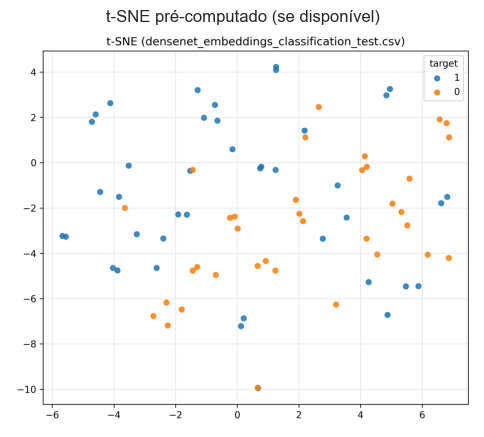

In [14]:
# t-SNE / UMAP de embeddings
emb_train = OUT_DIR / 'densenet_embeddings_classification_train.csv'
tsne_png = OUT_DIR / 'tsne_densenet_embeddings_classification_test.png'
if RUN_TSNE and sklearn is not None and emb_train.exists():
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    df_emb = pd.read_csv(emb_train)
    numeric_cols = [c for c in df_emb.columns if c.isdigit()]
    X = df_emb[numeric_cols].astype(float).values
    X = StandardScaler().fit_transform(X)
    X = X[:500]
    y = df_emb['target'][:len(X)] if 'target' in df_emb.columns else np.zeros(len(X))
    coords = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
    plt.scatter(coords[:,0], coords[:,1], c=y, cmap='viridis', s=12); plt.title('t-SNE (500 amostras)'); plt.show()
else:
    show_png(tsne_png, 't-SNE pré-computado (se disponível)')


,timestamp,model,val_accuracy,test_accuracy,training_time_seconds
6,2025-11-29 20:54:12,DenseNet_classification_RL,0.482143,0.545455,NaN
5,2025-11-29 20:47:14,DenseNet_classification,0.454545,0.454545,147.441527
4,2025-11-29 20:29:44,XGBoost,NaN,NaN,39.700805
3,2025-11-29 20:28:49,SVM,0.625000,0.623377,10.280897
2,2025-11-29 20:27:52,DenseNet_regression,NaN,NaN,517.276100
1,2025-11-29 20:07:59,DenseNet_classification_RL,0.660714,0.545455,NaN
0,2025-11-29 19:56:00,DenseNet_classification,0.532468,0.532468,295.890356


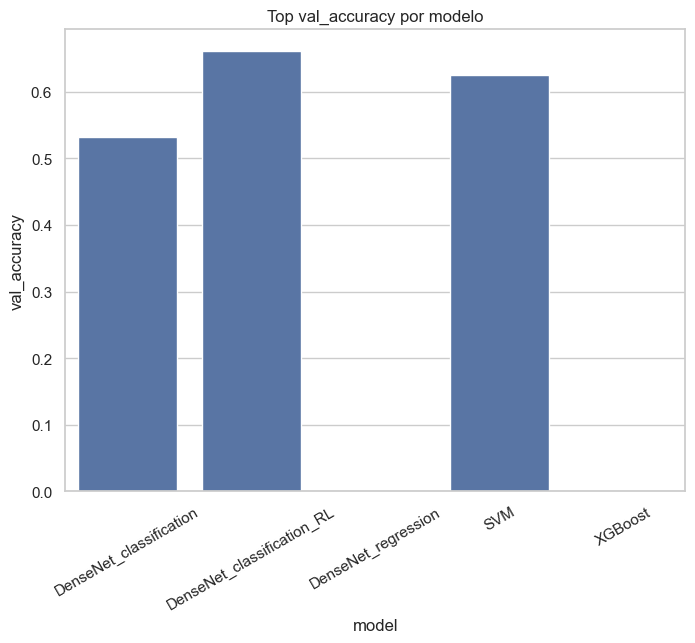

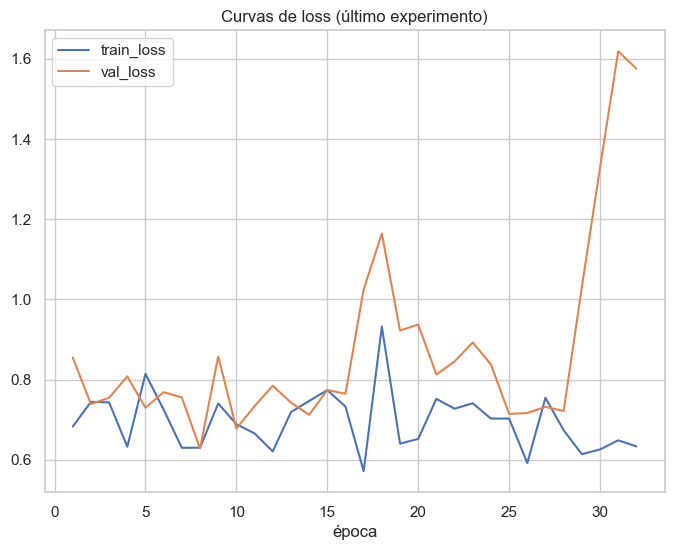

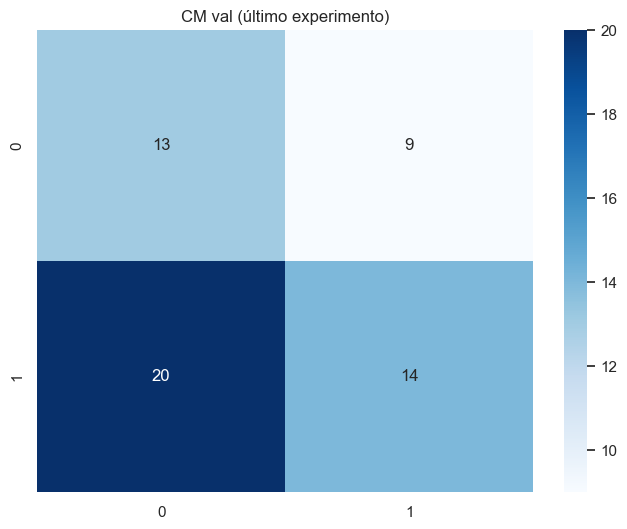

In [15]:
# Resumo de histórico de experimentos (se existir JSON)
hist_path = OUT_DIR / 'training_experiments.json'
if hist_path.exists():
    import json
    history = json.loads(hist_path.read_text())
    df_hist = pd.json_normalize(history) if history else pd.DataFrame()
    if not df_hist.empty:
        cols = [c for c in ['timestamp','model','val_accuracy','test_accuracy','training_time_seconds'] if c in df_hist.columns]
        display(df_hist[cols].sort_values('timestamp', ascending=False).head(10))
        if 'val_accuracy' in df_hist.columns and 'model' in df_hist.columns:
            sns.barplot(df_hist, x='model', y='val_accuracy', estimator=max, errorbar=None)
            plt.xticks(rotation=30); plt.title('Top val_accuracy por modelo'); plt.show()
        # Curvas do último experimento, se houver
        last = history[-1]
        lc = last.get('learning_curves') or {}
        if lc:
            epochs = range(1, len(lc.get('train_loss', []))+1)
            if epochs:
                plt.plot(epochs, lc.get('train_loss', []), label='train_loss')
                if lc.get('val_loss'): plt.plot(epochs, lc['val_loss'], label='val_loss')
                plt.legend(); plt.title('Curvas de loss (último experimento)'); plt.xlabel('época'); plt.show()
        cm = last.get('val_confusion_matrix')
        if cm is not None:
            import numpy as np
            cm = np.array(cm)
            if cm.size:
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('CM val (último experimento)'); plt.show()
    else:
        print('Histórico vazio.')
else:
    print('Nenhum training_experiments.json encontrado.')


## Conclusões rápidas
- Pipeline linear e sem GUI.
- `DEMO_MODE=True` carrega artefatos prontos e roda rápido.
- Para refazer etapas pesadas, altere `RUN_*` e garanta dependências.
- Para novos dados, ajuste `AXL_DIR`/`DEMOGRAPHICS` e reexecute descritores/dataset.

## Mapeamento notebook → ações da GUI
- Carregamento dados / flags: equivale à tela inicial/configuração.
- Visualização fatia/segmentação: corresponde à navegação/segmentação manual.
- Construção do dataset exam-level: botão "Criar Dataset".
- SVM: botão "Treinar SVM".
- XGBoost: botão de regressão.
- DenseNet treino leve/full: botões de treino DenseNet (class/reg).
- Visualizações de descritores/heatmap: botão de visualizações.
- Embeddings t-SNE/UMAP: script CLI integrado.
- Histórico de experimentos: botão "Ver Histórico".
